# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [9]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

# os.mkdir('data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O data/data.zip
!unzip "data/data.zip" -d "./data/"
os.system("rm ./data/data.zip")
data_dir = '/data/'


--2025-04-24 17:32:09--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 142.250.176.206, 2607:f8b0:4006:81c::200e
Connecting to docs.google.com (docs.google.com)|142.250.176.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2025-04-24 17:32:10--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.40.193, 2607:f8b0:4006:822::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.40.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘data/data.zip’

data/data.zip       100%[===================>]   5.92M  6.98MB/s    in 0.8s  

Utils Functions.

In [14]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "/data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---
For the geometry of the Lambertian n-dot-l lighting, we have the unit surface normal of an arbitrary patch as $dA$ and the following unit-length direction **toward** the light source.
$$
\mathbf n \in \mathbb R^{3},\qquad
\lVert\mathbf n\rVert = 1
$$

$$
\mathbf l \in \mathbb R^{3},\qquad 
\lVert\mathbf l\rVert = 1
$$

---

#### Where does the dot product come from?  
The dot product comes from the **irradiance** $E$ hitting the patch and is proportional to the component of $\mathbf l$ that is perpendicular to the surface:

$$
E \;\propto\; \cos\theta 
           \;=\; \frac{\mathbf n\cdot\mathbf l}
                        {\lVert\mathbf n\rVert\lVert\mathbf l\rVert}
           \;=\; \mathbf n\cdot\mathbf l ,
$$

because $\theta$ is the angle between $\mathbf n$ and $\mathbf l$. So the Lambertian dot product ***n·l*** writes the **exitant radiance**.

$$
L_o = \rho\,(\mathbf n\!\cdot\!\mathbf l)_+ ,
$$
where $\rho$ is the albedo and $(\cdot)_+=\max(\cdot,0)$.

---

#### Role of the projected area (Fig.​ 2b)  
The patch $dA$ is projected area onto a plane orthogonal to $\mathbf l$ as
$$
dA_\text{proj} = dA\;\cos\theta = dA\,(\mathbf n\cdot\mathbf l).
$$

and because the light delivers a constant power per unit **projected** area $dA_\text{proj}$, the flux absorbed by the actual patch is reduced by the same $\cos\theta$ factor producing the same *n·l*.

---

#### Why does the viewing direction not matter?  
A **Lambertian** surface reradiates the absorbed energy **uniformly in all directions**; its Bidirectional Reflectance Distribution Function (BRDF) is a constant $\rho/\pi$.  
Then, once the incident irradiance has been scaled by $(\mathbf n\cdot\mathbf l)_+$, the radiance leaving the surface is independent of the camera direction $\mathbf v$.  Only $\mathbf n$ and $\mathbf l$ appear in the formula.

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

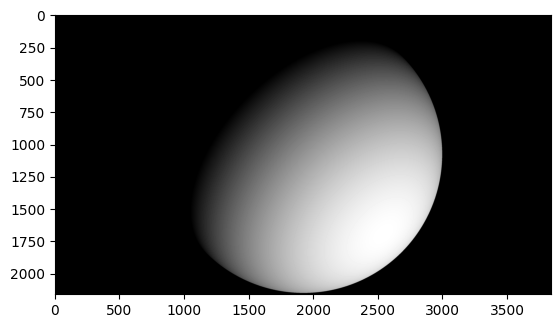

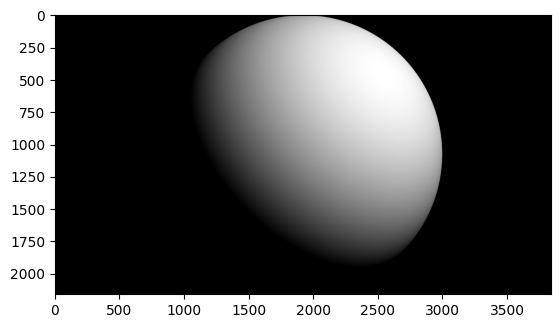

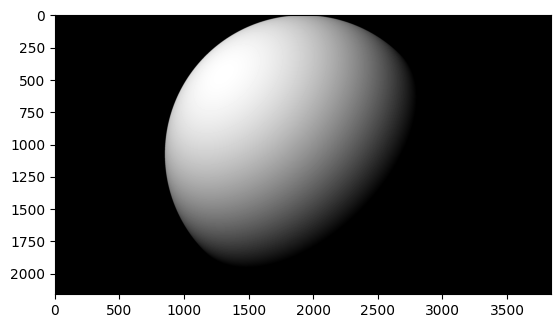

In [15]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """
    # Orthographic ray grid centered and with units(cm)
    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)

    # Depth of visible hemisphere aka positive-z
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None

    ### YOUR CODE HERE
    visible = Z > 0

    # Surface normals  n = (x-xc, y-yc, z-zc) / r
    N = np.zeros((*Z.shape, 3), dtype=np.float64)
    N[..., 0] = X - center[0]
    N[..., 1] = Y - center[1]
    N[..., 2] = Z - center[2]

    # Normalize, and not allow divide-by-zero outside the sphere
    nlen = np.linalg.norm(N, axis=-1, keepdims=True)
    nlen[nlen == 0] = 1.0
    N /= nlen

    # Unit light direction
    l = light / np.linalg.norm(light)

    # Lambertian n·l (no albedo term) and clamping to [0,1]
    image = np.maximum(
        0.0,
        N[..., 0] * l[0] + N[..., 1] * l[1] + N[..., 2] * l[2]
    )

    # Zero background
    image[~visible] = 0.0
    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

data_dir = './data/'
I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [16]:
### YOUR CODE HERE
# I, L, s have already been loaded by `loadData`
U, S, Vt = np.linalg.svd(I, full_matrices=False)
print("Singular values of I:", S)
### END YOUR CODE

Singular values of I: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---
From the given model
$$
I \;=\; L^{\top} B,
$$

* $L\in\mathbb R^{3\times 7}$ stacks the **7** known lighting directions (each column unit-length).  
* $B\in\mathbb R^{3\times P}$ stacks the **pseudonormals** $b_p = \alpha_p\,\mathbf n_p$ of the $P$ pixels.

Because both $L^{\top}$ and $B$ have **at most rank 3**, their product satisfies  


So in noise-free, perfectly Lambertian data we expect **exactly three non-zero singular values**; additional singular values should be ≈ 0 and arise only from imaging noise and numerical error.

#### Do the singular values agree with the rank-3 requirement?
Yes, the SVD values printed above do align with the rank-3 alignment for non-noise-free data
---

### Q 1 (d) Estimating pseudonormals (20 points)

In [17]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    # Pre-compute the 3×7 pseudoinverse of Lᵀ:  (L Lᵀ)⁻¹ L
    LLt_inv_L = np.linalg.solve(L @ L.T, L)      # numerically stable solve
    # Least-squares solution for all pixels at once
    B = LLt_inv_L @ I                            # (3×7) · (7×P) → (3×P)
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

For every pixel $p$ we have the intensity vector  

$$
I_p \;\in\;\mathbb R^{7},\qquad\; I_p \;=\; L^{\top}\,b_p ,
$$

where  

* $L\in\mathbb R^{3\times 7}$ stacks the **known** lighting directions,  
* $b_p=\alpha_p\,\mathbf n_p\in\mathbb R^{3}$ is the least squares **pseudonormal** we're trying to make.

---

#### Getting the least squares reduced matrix

If we vectorise *all* pixels, the image matrix $I\in\mathbb R^{7\times P}$ and the pseudonormal
matrix $B\in\mathbb R^{3\times P}$ satisfy  

$$
I \;=\; L^{\top}\,B .
$$

A naïve least-squares formulation would create  

$$
A \;=\; I_P \otimes L^{\top}\in\mathbb R^{(7P)\times(3P)},\qquad
y \;=\; \operatorname{vec}(I),
$$

and solve $Ax=y$ for $x=\operatorname{vec}(B)$.
Because $A$ quickly becomes gigantic, we instead exploit the separable structure and
solve **per pixel** in closed form:

$$
B
  \;=\; (L\,L^{\top})^{-1}\,L\;I .
$$

The $3\times 3$ matrix $(L\,L^{\top})$ is combines the information from the pixel using least squares


---


### Q 1 (e) Albedos and normals (10 points)

---


For every pixel $p$ the calibrated photometric-stereo step (part d) produced a **pseudonormal**

$$
\mathbf b_p \;=\; \alpha_p\,\mathbf n_p ,
$$

where  

* $ \alpha_p \ge 0 $ is the *albedo* aka a scalar reflectance,
* $ \mathbf n_p \in \mathbb R^{3},\; \lVert\mathbf n_p\rVert = 1 $ is the outward unit normal.

Therefore  

$$
\boxed{\;
  \alpha_p \;=\; \lVert\mathbf b_p\rVert_2 ,\qquad
  \mathbf n_p \;=\; \dfrac{\mathbf b_p}{\alpha_p}\;
}.
$$

---

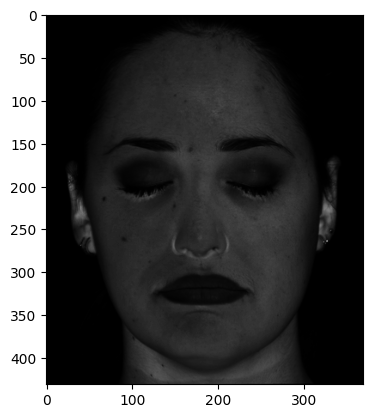

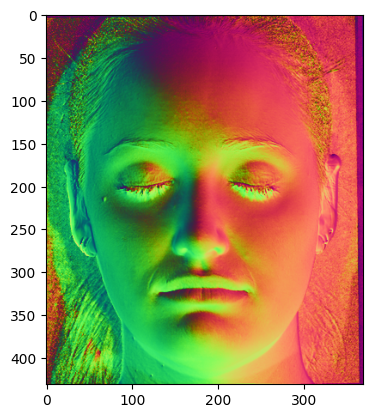

In [18]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE
    # l2-norm of every column → albedo vector (shape (P,))
    albedos = np.linalg.norm(B, axis=0)

    # Avoid division by zero (for completely dark / masked pixels)
    eps = 1e-8
    normals = B / (albedos + eps)[None, :]
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

The surface will be a height field  

$$
\mathbf s(x,y)\;=\;
\begin{bmatrix}
x\\[2pt] y\\[2pt] z
\end{bmatrix}
\;=\;
\begin{bmatrix}
x\\[2pt] y\\[2pt] f(x,y)
\end{bmatrix},
\qquad z=f(x,y).
$$

We then get the tangent vectors
$$
\mathbf s_x \;=\;\frac{\partial\mathbf s}{\partial x}
              \;=\;\begin{bmatrix}1\\0\\f_x\end{bmatrix},\qquad
\mathbf s_y \;=\;\frac{\partial\mathbf s}{\partial y}
              \;=\;\begin{bmatrix}0\\1\\f_y\end{bmatrix}.
$$

$$
\mathbf n' \;=\; \mathbf s_x \times \mathbf s_y
      \;=\;
      \begin{vmatrix}
      \mathbf i & \mathbf j & \mathbf k\\
      1 & 0 & f_x\\
      0 & 1 & f_y
      \end{vmatrix}
      \;=\;
      \begin{bmatrix}
      -f_x\\[4pt]
      -f_y\\[4pt]
      1
      \end{bmatrix}.
$$

Which gives us the not yet normalized surface normal
$$
\mathbf n \;=\;\frac{\mathbf n'}{\lVert\mathbf n'\rVert_2}
            \;=\;
            \frac{1}{\sqrt{f_x^{\,2}+f_y^{\,2}+1}}\,
            \begin{bmatrix}-f_x\\[2pt]-f_y\\[2pt]1\end{bmatrix}
            \;=\;
            \begin{bmatrix}n_1\\ n_2\\ n_3\end{bmatrix}.
$$

And getting the unit normal

$$
n_1 \;=\; -\frac{f_x}{\sqrt{f_x^{\,2}+f_y^{\,2}+1}},\qquad
n_3 \;=\;  \frac{1}{\sqrt{f_x^{\,2}+f_y^{\,2}+1}} .
$$


Dividing the first by the third (and similarly for $y$) removes the common denominator:

$$
\boxed{\,f_x \;=\; -\dfrac{n_1}{n_3}},\qquad
\boxed{\,f_y \;=\; -\dfrac{n_2}{n_3}}.
$$

So we get the partial derivatives of the depth map directly from the components of the unit surface normal.

Given the discrete fields $f_x(x,y)$ and $f_y(x,y)$  from the normals,we integrate them to get the function $f(x,y)$.
Because noise and discretization make the gradients **non-integrable**
($\partial f_x/\partial y \neq \partial f_y/\partial x$),
we first project $(f_x,f_y)$ onto the space of integrable gradients
using the Frankot–Chellappa algorithm implemented in `integrateFrankot`,
and then take the inverse FFT to get the depth map $f$.

---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

Given  

$$
g =
\begin{bmatrix}
 1 &  2 &  3 &  4\\
 5 &  6 &  7 &  8\\
 9 & 10 & 11 & 12\\
13 & 14 & 15 & 16
\end{bmatrix},
\qquad
g(x_i,y_j)=g_{j,i},
$$
with indexing origin $(0,0)$ at the **top-left**.

---

### Forward finite differences  

$$
g_x(i,j) = g(i+1,j)-g(i,j),\qquad
g_y(i,j) = g(i,j+1)-g(i,j).
$$

$$
g_x =
\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix},\quad
g_y =
\begin{bmatrix}
4 & 4 & 4 & 4\\
4 & 4 & 4 & 4\\
4 & 4 & 4 & 4
\end{bmatrix}.
$$

---

### 1. First reconstruction procedure 
- Start with boundary value $g(0,0)=1$.  
- Use $g_x$ to fill the **first row**  
  $g(1,0)=1+1=2,\; g(2,0)=3,\; g(3,0)=4$.  
- Use $g_y$ down each column to complete the grid  
  e.g. $g(0,1)=1+4=5,\; g(0,2)=9,\; g(0,3)=13$, etc.  

Result: exact reproduction of the original $g$.

---

### 2. Second reconstruction procedure   
- Fill the **first column** with $g_y$  
  $g(0,1)=5,\; g(0,2)=9,\; g(0,3)=13$.  
- Within every row use $g_x$ to fill the rest  
  e.g. $g(1,1)=5+1=6,\; g(2,1)=7,\dots$.  

We recover the original $g$.  
Because both paths lead to the **same** surface, $(g_x,g_y)$ are, **integrable** and satisfy the discrete curl-free condition 

$$
g_x(i,j+1)-g_x(i,j) \;=\;
g_y(i+1,j)-g_y(i,j)\quad\forall i,j .
$$

So they are the same
---

### Making the gradients non-integrable  

Change a single gradient entry, e.g.  

$$
g_x(2,1) \leftarrow 2 \quad (\text{was }1).
$$

Now  
$g_x(i,j+1)-g_x(i,j)$ and $g_y(i+1,j)-g_y(i,j)$ differ at
$(i,j)=(2,1)$, so the discrete curl is non-zero and procedures A and B
produce **inconsistent** surfaces.  The modified gradients are **non-integrable**.

---

### Why photometric-stereo gradients are not perfectly integrable  

* Sensor noise and quantisation  
* Specular highlights, shadows, and non-Lambertian reflectance  
* Discretisation of derivatives on a pixel grid  

All introduce small discrepancies such that  
$\partial f_x/\partial y \neq \partial f_y/\partial x$.
The Frankot–Chellappa algorithm helps with this by projecting the noisy gradient field onto the nearest integrable (curl-free) field before
reconstructing the depth map.

---

### Q 1 (h): Shape estimation (10 points)

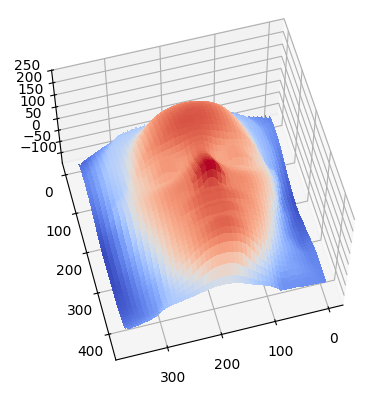

In [19]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    # reshape normal components into 2D fields
    n1 = normals[0, :].reshape(s)
    n2 = normals[1, :].reshape(s)
    n3 = normals[2, :].reshape(s)

    # compute partial derivatives: fx = -n1/n3, fy = -n2/n3
    eps = 1e-8
    fx = -n1 / (n3 + eps)
    fy = -n2 / (n3 + eps)

    # integrate using Frankot–Chellappa to enforce integrability
    surface = integrateFrankot(fx, fy)
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---
#### (a) Uncalibrated factorization via SVD

We want the rank-3 factorization 
$$
I \;=\; L^{T} B,
$$
where $I\in\mathbb R^{7\times P}$.  The optimal rank-3 approximation of $I$ in the Frobenius norm is found with its SVD:

1. Compute
   $$
     I \;=\; U\,\Sigma\,V^{T},
   $$
   with $U\in\mathbb R^{7\times 7}$, $\Sigma\in\mathbb R^{7\times P}$, $V\in\mathbb R^{P\times P}$.

2. Truncate to the top 3 singular values:
   $$
     U_3 = U[:,0:3],\quad
     \Sigma_3 = \Sigma[0:3,0:3],\quad
     V_3 = V[:,0:3].
   $$
   Then
   $$
     \widehat I = U_3\,\Sigma_3\,V_3^{T}
   $$
   is the best rank-3 approximation.

3.  We now factor $\widehat I$ as
   $$
     \widehat I
     = \bigl(U_3\,\Sigma_3^{1/2}\bigr)\,\bigl(\Sigma_3^{1/2}\,V_3^{T}\bigr)
     \;=\; \widehat L^{T}\,\widehat B,
   $$
   where
   $$
     \widehat L^{T} = U_3\,\Sigma_3^{1/2}\quad(7\times 3),
     \qquad
     \widehat B = \Sigma_3^{1/2}\,V_3^{T}\quad(3\times P).
   $$
   Hence
   $$
     \widehat L = \bigl(\Sigma_3^{1/2}\,U_3^{T}\bigr)\;\in\;\mathbb R^{3\times 7},
     \quad
     \widehat B \;\in\;\mathbb R^{3\times P}.
   $$

**Note:**  There remains a $3\times3$ ambiguity $G$: if
$\widehat L'\!\!= G\,\widehat L$ and $\widehat B' = G^{-T}\,\widehat B$, then $\widehat L'^{T}\,\widehat B' = \widehat L^{T}\,\widehat B$.  


---

### Q 2 (b): Calculation and visualization (10 points)

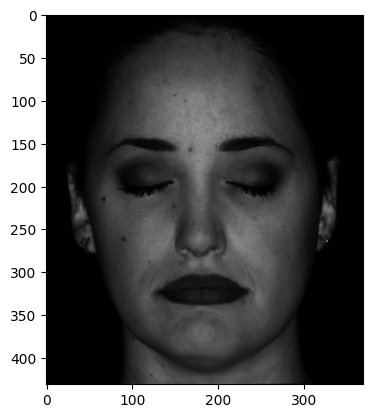

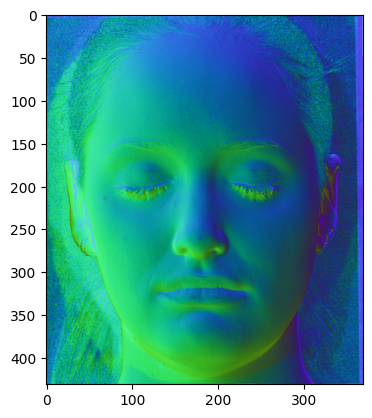

In [22]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	# SVD of I
	U, S, Vt = np.linalg.svd(I, full_matrices=False)
	# keep top-3 components
	U3   = U[:, :3]         # (7 x 3)
	V3t  = Vt[:3, :]        # (3 x P)
	s3   = S[:3]            # (3,)
	sqrtS3 = np.diag(np.sqrt(s3))  # (3 x 3)
	# 3) form pseudonormals and light matrix
	B = sqrtS3 @ V3t               # (3 x P)
	L = sqrtS3 @ U3.T              # (3 x 7)
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

We got the uncalibrated factorization via SVD:
$$
I = U_3\,\Sigma_3\,V_3^{T},
\quad
\widehat L^{T} = U_3\,\Sigma_3^{1/2},
\quad
\widehat B = \Sigma_3^{1/2}\,V_3^{T}.
$$
To keep $\widehat I = \widehat L^{T}\,\widehat B$ unchanged while altering $\widehat L,\widehat B$, insert any invertible $3\times3$ matrix $G$:
$
\widehat L'{}^{T} = G^{-1}\,\widehat L^{T}, 
\quad 
\widehat B' = G\,\widehat B.
$
Then
$$
\widehat L'{}^{T}\,\widehat B' 
= G^{-1}\,\widehat L^{T}\,G\,\widehat B
= \widehat L^{T}\,\widehat B,
$$
so the rendered images remain identical, but the individual $\widehat L$ and $\widehat B$ change.

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

It does not look like a face at all.
---

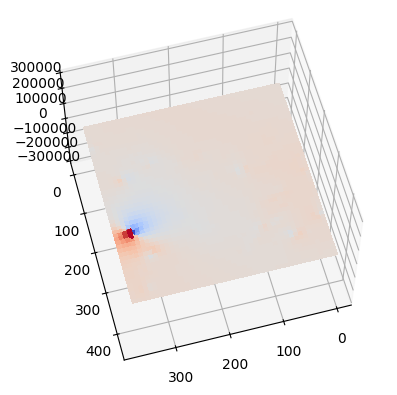

In [23]:
# Part 2 (d)
### YOUR CODE HERE
# Uncalibrated pseudonormals & unit normals
B_unc, L_est = estimatePseudonormalsUncalibrated(I)
alphas_unc, normals_unc = estimateAlbedosNormals(B_unc)

# Reshape normals into 2D fields
n1 = normals_unc[0, :].reshape(s)
n2 = normals_unc[1, :].reshape(s)
n3 = normals_unc[2, :].reshape(s)

# Compute partial derivatives
eps = 1e-8
fx_unc = -n1 / (n3 + eps)
fy_unc = -n2 / (n3 + eps)

# Integrate with Frankot–Chellappa
surface_unc = integrateFrankot(fx_unc, fy_unc)

# Display
plotSurface(surface_unc, suffix='_uncal')
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

Yes, it does now.
---


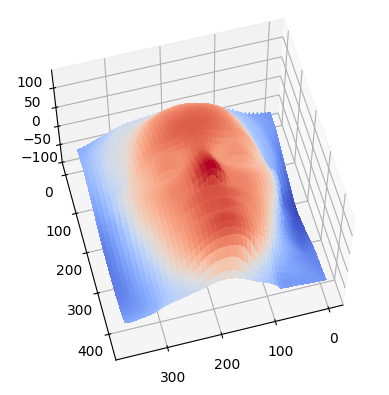

In [ ]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE

# Enforcing integrability on the pseudonormals
B_int = enforceIntegrability(B_unc, s)

# Recompute albedos & normals from the integrable pseudonormals
alphas_int, normals_int = estimateAlbedosNormals(B_int)

# Reshape and compute gradients
n1_i = normals_int[0, :].reshape(s)
n2_i = normals_int[1, :].reshape(s)
n3_i = normals_int[2, :].reshape(s)
fx_i = -n1_i / (n3_i + eps)
fy_i = -n2_i / (n3_i + eps)

# Integrate and display
surface_int = integrateFrankot(fx_i, fy_i)
plotSurface(surface_int, suffix='_int')
### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

Google told me that the name comes from the sculptural technique that also uses very shallow relief.

---

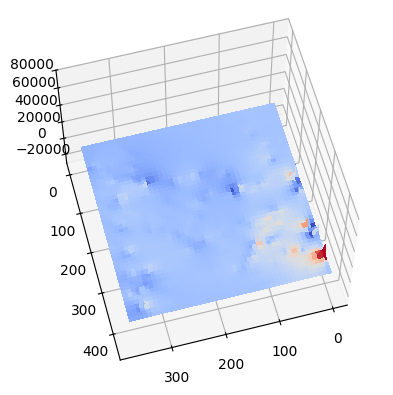

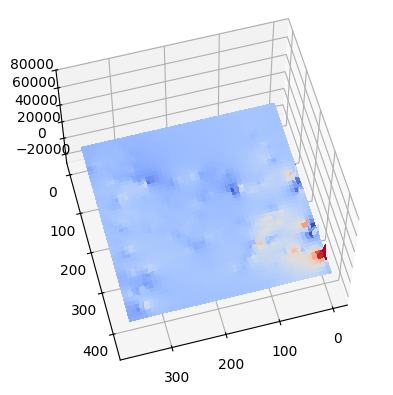

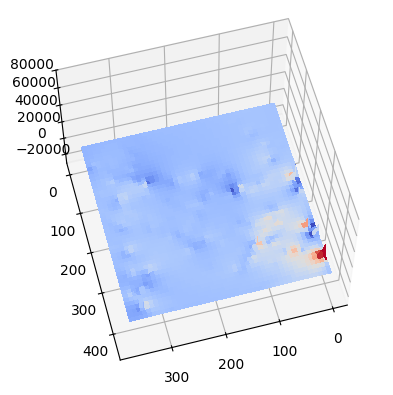

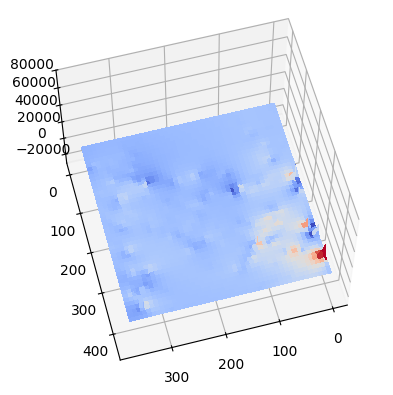

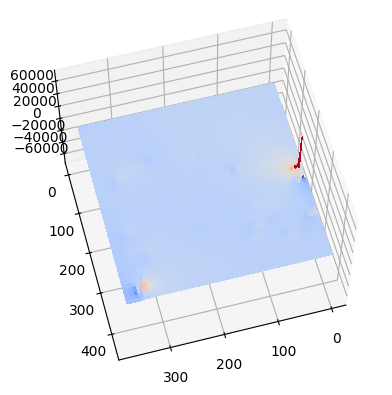

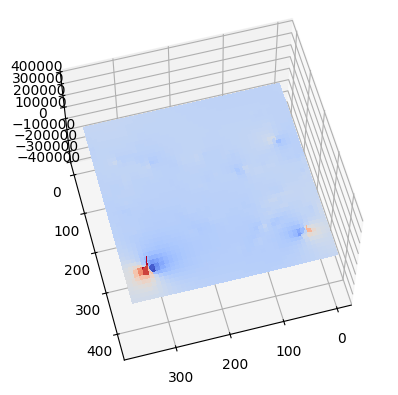

In [28]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')


# Part 2 (f)
### YOUR CODE HERE

# 1–2: varying μ (x-shear)
plotBasRelief(B, mu=0.3, nu=0.0, lam=1.0)
plotBasRelief(B, mu=-0.3, nu=0.0, lam=1.0)

# 3–4: varying ν (y-shear)
plotBasRelief(B, mu=0.0, nu=0.3, lam=1.0)
plotBasRelief(B, mu=0.0, nu=-0.3, lam=1.0)

# 5–6: varying λ (depth scale)
plotBasRelief(B, mu=0.0, nu=0.0, lam=0.5)
plotBasRelief(B, mu=0.0, nu=0.0, lam=2.0)
### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

To make the reconstructed surface as flat as possible, we choose the GBR parameters so that the depth‐scale factor tends to zero.  In the transform

$$
G \;=\;
\begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
\mu & \nu & \lambda
\end{pmatrix},
$$

we take
$$
\lambda \;\to\; +\infty
\quad\bigl(\Longrightarrow\;1/\lambda \to 0\bigr),
$$
and $\mu,\nu$ arbitrary.  Then
$$
G^{-T}
=\begin{pmatrix}
1 & 0 & -\mu/\lambda\\
0 & 1 & -\nu/\lambda\\
0 & 0 & 1/\lambda
\end{pmatrix}
\;\longrightarrow\;
\begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{pmatrix},
$$
so that all new gradients 
$\,f_x=-n'_1/n'_3$ and $f_y=-n'_2/n'_3$ vanish, which should create a flat (constant-$z$) surface.  

---

### Q 2 (h): More measurements

---

No—simply adding more images under *unknown* lighting directions does **not** resolve the GBR ambiguity.  For any number of pictures $I = L^{T}B$, we can apply the same transform
$$
G \;=\;\begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
\mu & \nu & \lambda
\end{pmatrix},
\quad \lambda>0,
$$
and set
$$
L'\;=\;G^{-T}L,
\quad
B'\;=\;G\,B,
$$
yet still have
$$
I \;=\;L^{T}B \;=\;(L')^{T}B'.
$$
Because this holds for *any* number of lighting directions, extra uncalibrated images cannot constrain $\mu,\nu,\lambda$. Only by **calibrating** the lights or adding other priors (e.g.\ known albedo, contours, shadows) can the ambiguity be broken. 

---